https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [ ]:
# Softmax confidently wrong

# Logits start to high. You can change the bias2 to init with 0 instead of random numbers
# Weights should also be small but never 0 because of syncronosation opties
# Bij training is the start loss too high (Around 25 - 30) Fake Confidence
# For this project you know the biggest propability loss. Because everyhing (27 chars) have the same change to be the first character.
# So loss is around 3.3 at init
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# Tanh Layer too saturated

# Hidden Layer (h) werkt slecht bij een flat tail (-1 or 1)
# Killing the gradient/als de output er close bij 1 / -1 is
# Je wilt Dead Neurons voorkomen, weights and bias never learn
# Daarom moet hpreact aka hidden layer pre-activation dichter naar 0 toe, net zoals logits

##  De eerste training uitdraaien en daar kijken wat er op de hidden layers gebeurd

In [ ]:
# https://pytorch.org/docs/stable/nn.init.html
# torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
# Fills the input Tensor with values according to the method described in Delving deep into rectifiers: \
#         Surpassing human-level performance on ImageNet classification

#   So Gain / Square of fan in
#   or
#   (5/3)/((n_embd * block_size)**0.5)

In [ ]:
# # Batch Normalization is a technique that normalizes the activations of each layer in a neural network, \
#   stabilizing the training process, allowing higher learning rates, and acting as a regularizer to improve generalization

# Batch Normalization normalizes the activations of each layer in a neural network by subtracting the batch \
#      mean and dividing by the batch standard deviation.

# Scale and Shift

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)    * (5/3)/((n_embd * block_size)**0.5)                              #* 0.2
# b1 = torch.randn(n_hidden,                        generator=g)    * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g)    * 0.01 # logits very small at init. Dont put Weights on 0
b2 = torch.randn(vocab_size,                      generator=g)    * 0 # Not a bias of random numbers at init

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1
  # -------------------------------------------------------------
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2788
  10000/ 200000: 2.1573
  20000/ 200000: 2.3661
  30000/ 200000: 2.1708
  40000/ 200000: 2.2585
  50000/ 200000: 2.7153
  60000/ 200000: 2.0828
  70000/ 200000: 2.3331
  80000/ 200000: 2.3124
  90000/ 200000: 1.9479
 100000/ 200000: 1.8613
 110000/ 200000: 1.7870
 120000/ 200000: 2.3108
 130000/ 200000: 1.9558
 140000/ 200000: 2.4277
 150000/ 200000: 2.0879
 160000/ 200000: 2.0539
 170000/ 200000: 2.3074
 180000/ 200000: 1.8473
 190000/ 200000: 2.1584


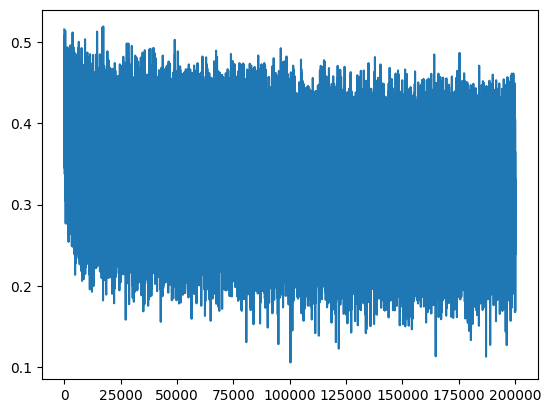

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

# with torch.no_grad():
#   # pass the training set through
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 # + b1
#   # measure the mean/std over the entire training set
#   bnmean = hpreact.mean(0, keepdim=True)
#   bnstd = hpreact.std(0, keepdim=True)

In [ ]:
##  https://pytorch.org/docs/stable/generated/torch.no_grad.html

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066537618637085
val 2.1117324829101562


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(242222883 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

qaibht.
tygigraclyr.
fazviviz.
fatmu.
phmbiq.
gricelyssafrantim.
kevanyah.
jasbbiahmsttv.
qulbeifatsh.
britshquenvighl.
feymastamris.
sha.
selssimredgrefttonsthugfklamsimdhvi.
faidhkauriplrrang.
kwexthal.
fahdias.
mckerranncharmaribfir.
vnyyah.
blestap.
faghn.


In [ ]:
1:03